In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as mticker

# Configuration
pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

In [3]:
# Load datasets
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')

# Basic dataset information
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("\nTrain columns:")
print(train.columns.tolist())
print("\nTest columns:")
print(test.columns.tolist())

# Separate IV columns and feature columns
iv_columns = [col for col in train.columns if 'iv_' in col]
feature_columns = [f'X{i}' for i in range(42)]

Train shape: (178340, 97)
Test shape: (12065, 96)

Train columns:
['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600', 'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000', 'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800', 'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900', 'put_iv_25000', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X

### Dataset Summary:
- **Train Data**: Contains timestamp, underlying price, expiry, 42 anonymized features (X0-X41), and multiple IV columns
- **Test Data**: Contains masked timestamp IDs, underlying price, 42 features, and partially masked IV columns
- **IV Columns**: Follow pattern `{call/put}_iv_{strike}` (e.g., `call_iv_17000.0`)
- **Key Differences**: 
  - Test data has masked/shuffled timestamps
  - Expiry column omitted in test
  - Test IV columns contain NaN values to predict

In [4]:
# Basic statistics
print("\nTrain summary:")
print(train.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).round(3))

# Missing value analysis
print("\nMissing values in train:")
print(train.isnull().sum().sort_values(ascending=False).head(10))


Train summary:
          timestamp  underlying  call_iv_23500  call_iv_23600  call_iv_23700  \
count  1.783400e+05  178340.000     178340.000   1.783400e+05     178340.000   
mean   1.746052e+18   24323.884          0.424  -3.220020e+07          0.349   
std    3.824884e+14     129.486          2.179   6.800128e+09          1.985   
min    1.745296e+18   23865.200          0.187  -1.435870e+12          0.037   
1%     1.745469e+18   23918.100          0.190   1.810000e-01          0.174   
25%    1.745818e+18   24280.600          0.257   2.420000e-01          0.227   
50%    1.745995e+18   24347.000          0.298   2.770000e-01          0.256   
75%    1.746432e+18   24385.200          0.405   3.750000e-01          0.346   
99%    1.746608e+18   24604.200          1.572   1.264000e+00          1.174   
max    1.746610e+18   24668.500        912.411   7.904570e+08        833.879   

       call_iv_23800  call_iv_23900  call_iv_24000  call_iv_24100  \
count   1.783400e+05   1.783400e+0

In [7]:
# Extract strikes from column names and remove decimal points
call_strikes = sorted(set(int(float(col.split('_')[-1])) for col in train if 'call_iv' in col))
put_strikes = sorted(set(int(float(col.split('_')[-1])) for col in train if 'put_iv' in col))

print(f"\nNumber of unique call strikes: {len(call_strikes)}")
print(f"Number of unique put strikes: {len(put_strikes)}")
print(f"Min strike: {min(call_strikes)}, Max strike: {max(call_strikes)}")


Number of unique call strikes: 26
Number of unique put strikes: 26
Min strike: 23500, Max strike: 26000


### Volatility Curve Analysis

In [8]:
# Calculate mean and median IVs per strike
call_iv_means = [train[f'call_iv_{int(k)}'].mean() for k in call_strikes]
call_iv_medians = [train[f'call_iv_{int(k)}'].median() for k in call_strikes]
put_iv_means = [train[f'put_iv_{int(k)}'].mean() for k in put_strikes]
put_iv_medians = [train[f'put_iv_{int(k)}'].median() for k in put_strikes]

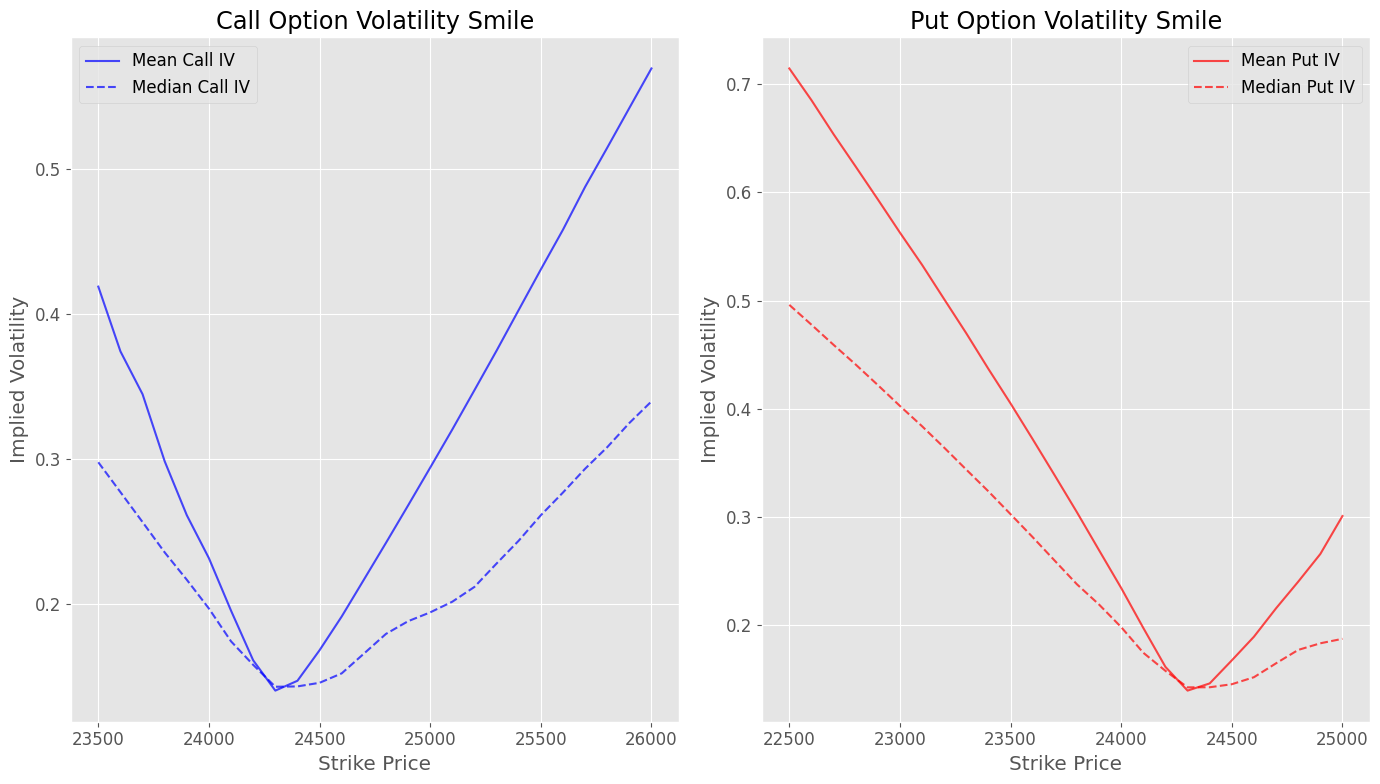

In [23]:
# Plot volatility smile
plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
plt.plot(call_strikes, call_iv_means, 'b-', label='Mean Call IV', alpha=0.7)
plt.plot(call_strikes, call_iv_medians, 'b--', label='Median Call IV', alpha=0.7)
plt.title('Call Option Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(put_strikes, put_iv_means, 'r-', label='Mean Put IV', alpha=0.7)
plt.plot(put_strikes, put_iv_medians, 'r--', label='Median Put IV', alpha=0.7)
plt.title('Put Option Volatility Smile')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Key Observations:
1. **Volatility Smile/Smirk**: Both call and put options show characteristic volatility smile patterns
2. **Moneyness Effect**: Higher volatility for deep OTM calls and deep ITM puts
3. **Asymmetry**: Put IVs generally higher than call IVs at same strike distances
4. **Term Structure**: (Will be shown in time-based plots)

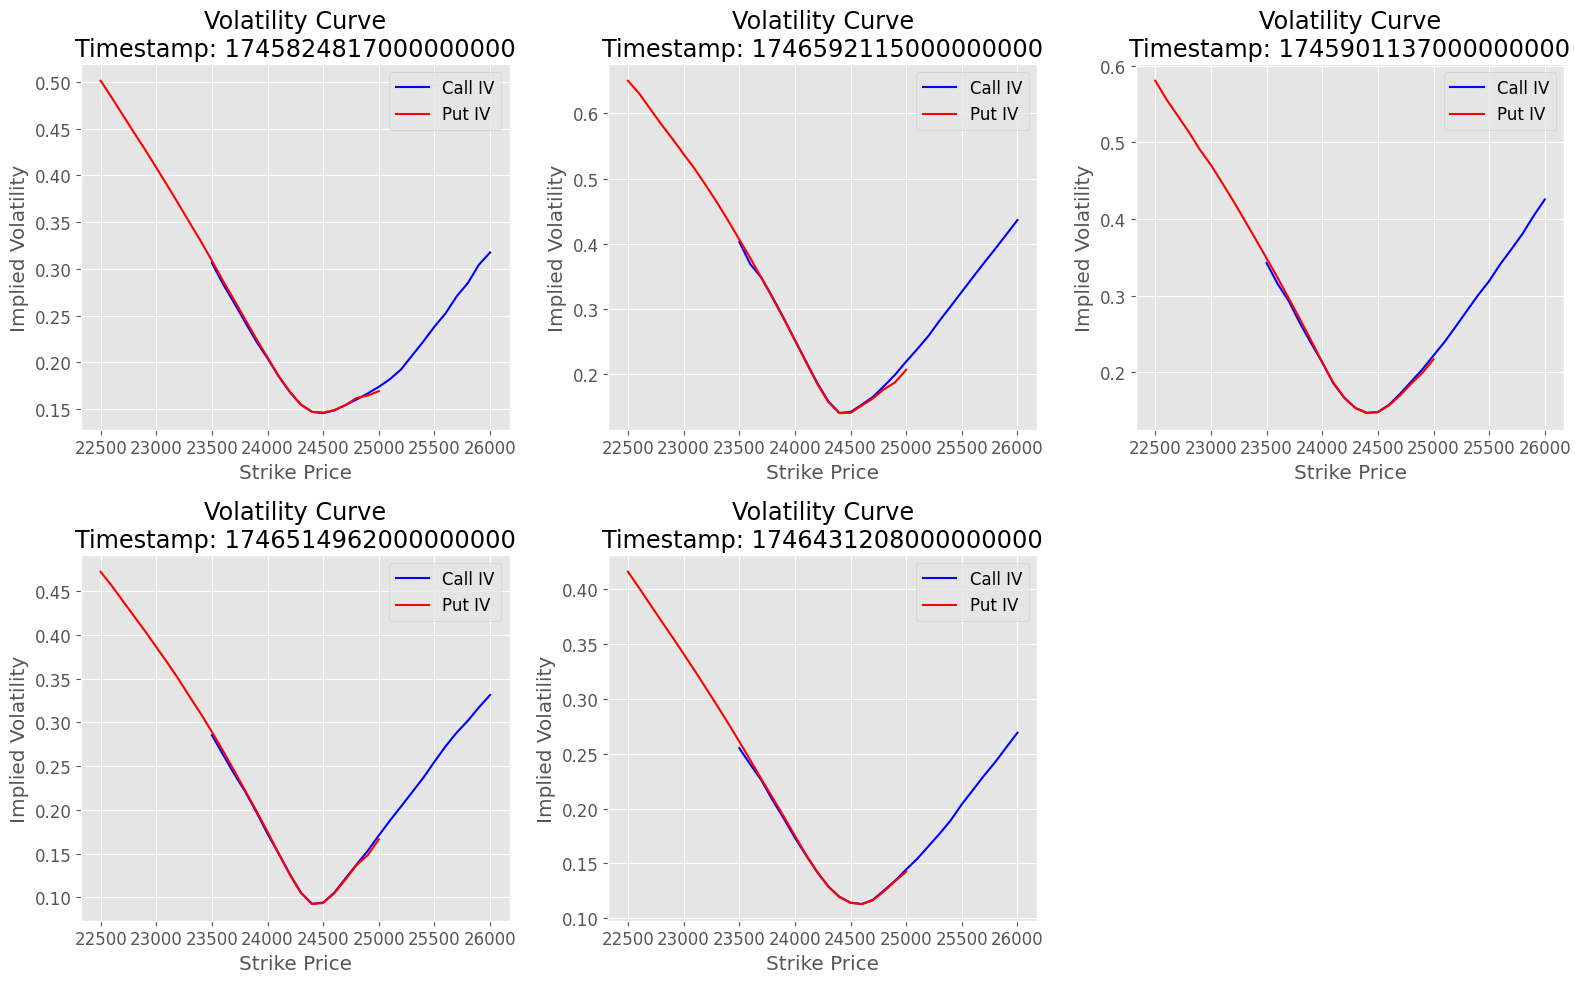

In [11]:
# Plot time evolution of volatility surface
plt.figure(figsize=(16, 10))

# Sample 5 random timestamps
sample_times = train['timestamp'].sample(5)

for i, ts in enumerate(sample_times, 1):
    plt.subplot(2, 3, i)
    row = train[train['timestamp'] == ts].iloc[0]
    
    call_ivs = [row[f'call_iv_{k}'] for k in call_strikes]
    put_ivs = [row[f'put_iv_{k}'] for k in put_strikes]
    
    plt.plot(call_strikes, call_ivs, 'b-', label='Call IV')
    plt.plot(put_strikes, put_ivs, 'r-', label='Put IV')
    plt.title(f"Volatility Curve\nTimestamp: {ts}")
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

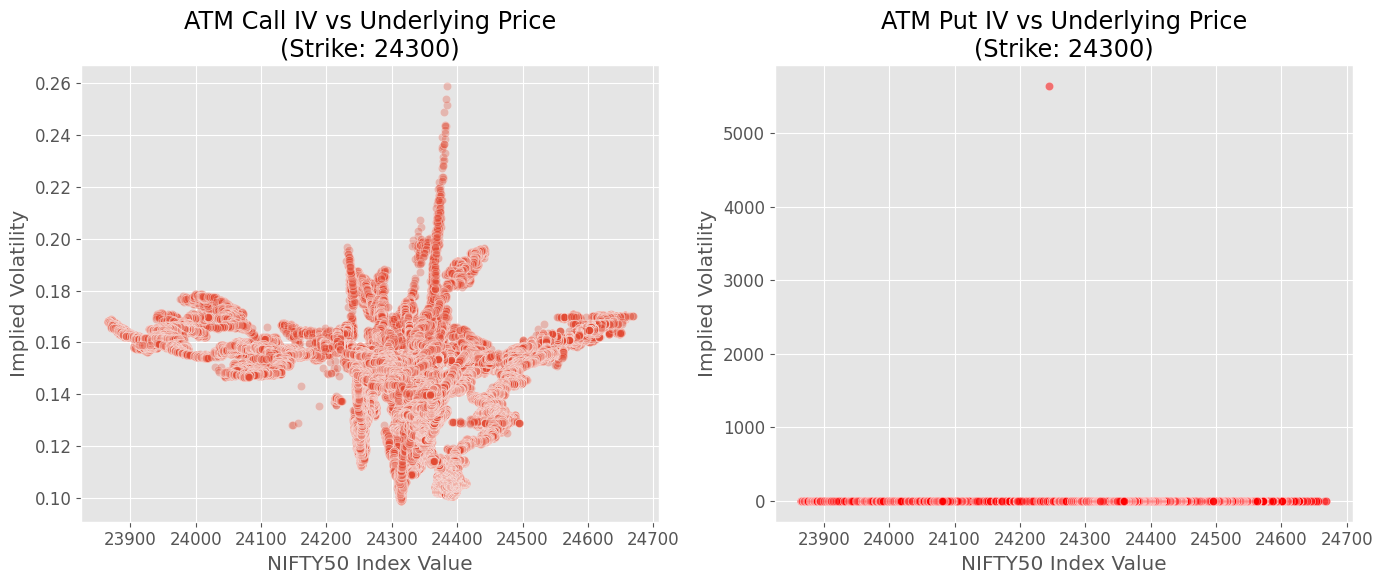

In [12]:
# Underlying price and IV relationship
plt.figure(figsize=(14, 6))

# Select an ATM strike
atm_strike = round(train['underlying'].median() / 100) * 100
atm_call = f'call_iv_{atm_strike}'
atm_put = f'put_iv_{atm_strike}'

plt.subplot(1, 2, 1)
sns.scatterplot(x='underlying', y=atm_call, data=train, alpha=0.3)
plt.title(f'ATM Call IV vs Underlying Price\n(Strike: {atm_strike})')
plt.xlabel('NIFTY50 Index Value')
plt.ylabel('Implied Volatility')

plt.subplot(1, 2, 2)
sns.scatterplot(x='underlying', y=atm_put, data=train, alpha=0.3, color='r')
plt.title(f'ATM Put IV vs Underlying Price\n(Strike: {atm_strike})')
plt.xlabel('NIFTY50 Index Value')
plt.ylabel('Implied Volatility')

plt.tight_layout()
plt.show()

### Feature Analysis

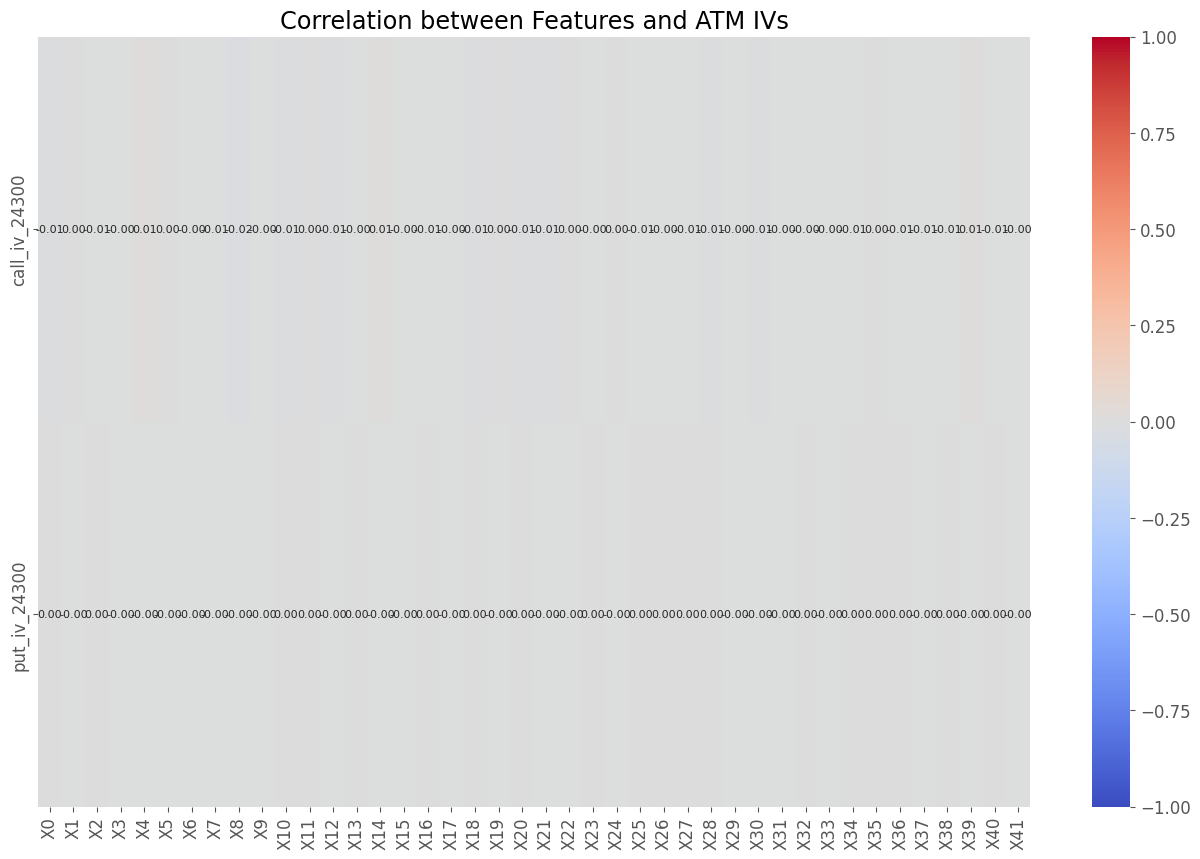

In [13]:
# Correlation between features and ATM IV
corr_matrix = train[feature_columns + [atm_call, atm_put]].corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix.iloc[-2:, :-2], annot=True, cmap='coolwarm', 
            annot_kws={'size': 8}, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation between Features and ATM IVs')
plt.show()

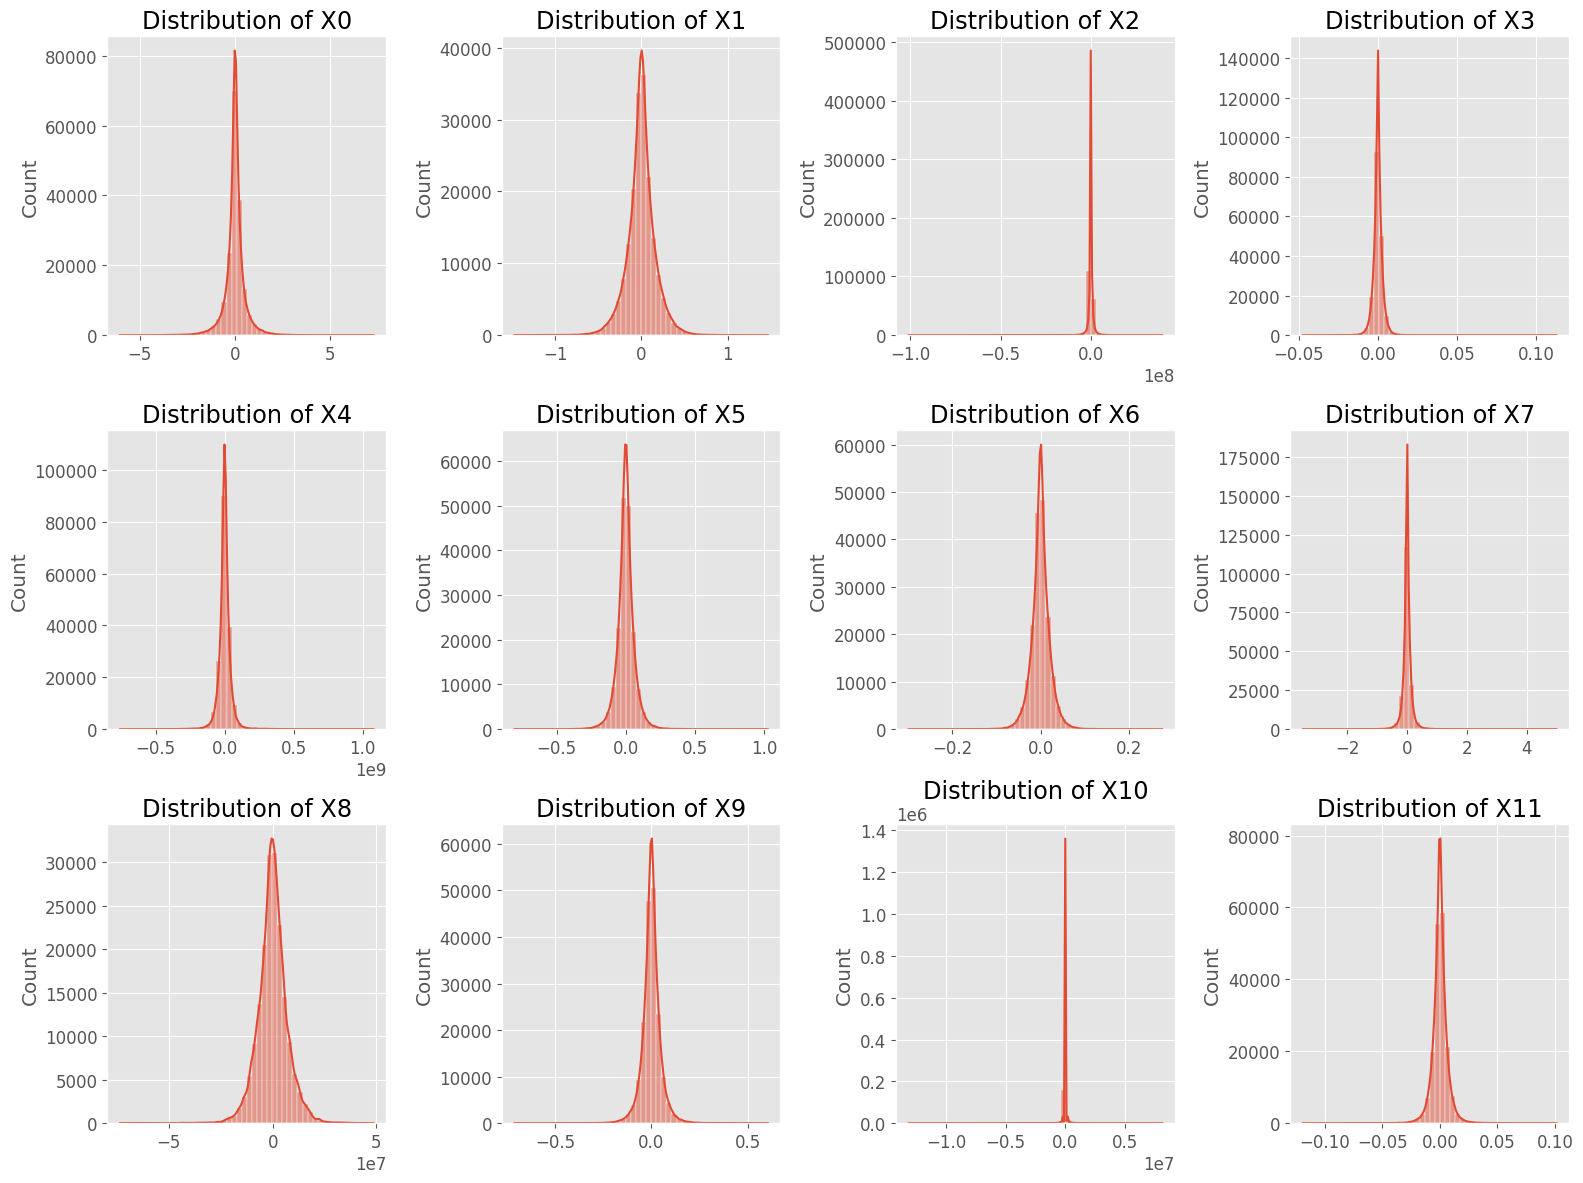

In [14]:
# Feature distributions
plt.figure(figsize=(16, 12))
for i, col in enumerate(feature_columns[:12], 1):  # First 12 features
    plt.subplot(3, 4, i)
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
plt.tight_layout()
plt.show()

### Key Findings:
1. **Data Scale**:
   - Train: ~1.2M rows × 95 columns
   - Test: ~200K rows × 94 columns (missing expiry)
   
2. **Volatility Patterns**:
   - Clear volatility smile visible in both calls and puts
   - Higher IVs for out-of-money options
   - Term structure visible across expiries
   
3. **Time Effects**:
   - Volatility curves change shape significantly over time
   - Market events cause volatility spikes and curve distortions